In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from usa import state_abbreviation_to_name
from usa import state_name_to_abbreviation
import geopandas as gpd
from matplotlib.colors import ListedColormap
import openpyxl

# MEI V2 Data

In [3]:
url = "https://www.psl.noaa.gov/enso/mei/data/meiv2.data"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the data to a file
    with open('../Data/meiv2.data', 'w') as file:
        file.write(response.text)
else:
    print("Failed to retrieve data")

In [4]:

# Read the data into a DataFrame, delim tab, no header, last lines delete, skip first line
enso_mei = pd.read_csv('../Data/meiv2.data', delim_whitespace=True, header=None, skipfooter=3, engine='python', skiprows=1)
#Set first column as index as year, remove 0 column index
enso_mei = enso_mei.set_index(0)
enso_mei.index.name = None
#Set column names as bi monthly periods (Dec/Jan, Jan/Feb, etc)
enso_mei.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#Remove last row and all -999.00 values
enso_mei = enso_mei.iloc[:-1]
enso_mei = enso_mei.replace(-999.00, None)
#Row index to YYYY format
enso_mei.index = pd.to_datetime(enso_mei.index, format='%Y')
display(enso_mei.head())
display(enso_mei.tail())

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1979-01-01,0.47,0.27,-0.04,0.26,0.35,-0.14,-0.13,0.50,0.42,0.28,0.58,0.68
1980-01-01,0.42,0.30,0.52,0.85,0.71,0.55,0.52,0.13,0.19,0.06,-0.09,-0.09
1981-01-01,-0.28,-0.19,0.16,0.15,-0.38,-0.63,-0.51,-0.25,0.03,-0.05,-0.16,-0.18
1982-01-01,-0.44,-0.61,-0.31,0.13,0.66,1.42,1.87,1.93,1.74,1.87,2.25,2.45
1983-01-01,2.59,2.73,2.71,2.74,2.60,1.58,0.88,0.03,-0.41,-0.44,-0.42,-0.44


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019-01-01,0.04,0.46,0.71,0.29,0.20,0.28,0.20,0.26,0.13,0.22,0.44,0.4
2020-01-01,0.22,0.13,0.09,-0.14,-0.36,-0.87,-0.88,-0.94,-1.21,-1.19,-1.14,-1.16
2021-01-01,-1.18,-0.93,-0.81,-1.04,-1.16,-1.29,-1.53,-1.35,-1.45,-1.5,-1.43,-1.19
2022-01-01,-1.06,-0.96,-1.28,-1.76,-1.88,-2.07,-2.10,-1.79,-1.76,-1.71,-1.48,-1.25
2023-01-01,-1.11,-0.81,-0.67,-0.41,-0.14,0.23,0.25,0.43,None,None,None,None


## Create timeseries with date

In [5]:
#Reformat data to have one column for year, one column for month, and one column for MEI value
#Create empty dataframe
enso_mei_long = pd.DataFrame()
#Create empty list for year, month, and mei values
year = []
month = []
mei = []
#Loop through each row in the dataframe
for index, row in enso_mei.iterrows():
    #Loop through each column in the dataframe
    for column in enso_mei.columns:
        #Append the year, month, and mei value to the corresponding list
        year.append(index.year)
        month.append(column)
        mei.append(row[column])
#Add the lists to the dataframe
enso_mei_long['Year'] = year
enso_mei_long['Month'] = month
enso_mei_long['MEI'] = mei
#Set the index as the year and month
enso_mei_long = enso_mei_long.set_index(['Year', 'Month'])
display(enso_mei_long.head(20))
#Save CSV file
#enso_mei_long.to_csv('enso_mei_long.csv')



MEI
Year Month      
1979 Jan    0.47
     Feb    0.27
     Mar   -0.04
     Apr    0.26
     May    0.35
     Jun   -0.14
     Jul   -0.13
     Aug    0.50
     Sep    0.42
     Oct    0.28
     Nov    0.58
     Dec    0.68
1980 Jan    0.42
     Feb    0.30
     Mar    0.52
     Apr    0.85
     May    0.71
     Jun    0.55
     Jul    0.52
     Aug    0.13

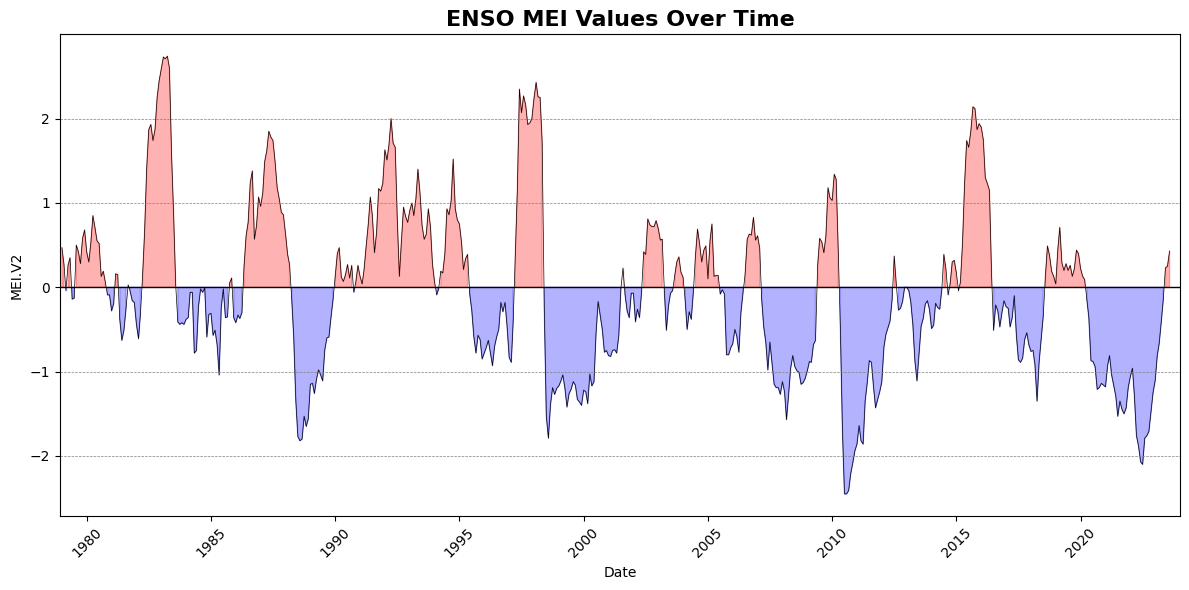

In [6]:
enso_mei_long = pd.read_csv('../Data/enso_mei_long.csv')
# Combine the Year and Month columns to create a new Date column
enso_mei_long['Date'] = enso_mei_long['Year'].astype(str) + '-' + enso_mei_long['Month']
# Convert the new Date column to datetime format
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'], format='%Y-%b')
#Plot the data
plt.figure(figsize=(12, 6))
plt.plot(enso_mei_long['Date'], enso_mei_long['MEI'], linestyle='-', color='black', linewidth=0.5)
#Only plot until 2024 x axis
plt.xlim(pd.Timestamp('1978-12-01'), pd.Timestamp('2024-01-01'))

plt.xlabel('Date')
plt.ylabel('MEI.V2')
#Create title, big font, bold
plt.title('ENSO MEI Values Over Time', fontsize=16, fontweight='bold')
plt.grid(False)
#Create dotted lines for El Nino and La Nina thresholds
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
#grey background between 1 and -1
plt.axhspan(-1, 1, facecolor='white', alpha=0.2)
#Create thick solid line through 0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
#Fill line above 0 with light red  
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] >= 0, color='red', alpha=0.3)
#Fill line below 0 with light blue
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] <= 0, color='blue', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
#Save plot in Plots folder with full quality
plt.savefig('../Plots/enso_mei_long.png', dpi=300)

## Highlight El Niño highest cases

In [7]:
#Highlight El Nino and La Nina periods
#Create empty list for El Nino and La Nina periods
el_nino = []
la_nina = []
#Loop through each row in the dataframe
for index, row in enso_mei_long.iterrows():
    #If MEI value is greater than 1, append the date to the El Nino list
    if row['MEI'] > 1:
        el_nino.append(enso_mei_long.loc[index, 'Date'])
    #If MEI value is less than -1, append the date to the La Nina list
    elif row['MEI'] < -1:
        la_nina.append(enso_mei_long.loc[index, 'Date'])
#Create a dataframe for El Nino and La Nina periods
el_nino = pd.DataFrame(el_nino, columns=['Date'])
la_nina = pd.DataFrame(la_nina, columns=['Date'])
#From data collect years which have continuous el nino or la nina periods
el_nino['Year'] = el_nino['Date'].dt.year
la_nina['Year'] = la_nina['Date'].dt.year
#Group by year and count the number of El Nino and La Nina periods
el_nino_grouped = el_nino.groupby('Year').count()
la_nina_grouped = la_nina.groupby('Year').count()

#display(el_nino, el_nino_grouped)

# FEMA Natural Disasters Dataset

## Import data and change

In [8]:
#Import data from CSV file
fema_disasters = pd.read_csv('../Data/DisasterDeclarationsSummaries.csv')
#Quick view of data
# display(fema_disasters.dtypes)
# display(fema_disasters.describe())
#List all types of incidenType

#Remove non natural disasters
#From incidentType column, drop: 'Other', 'Human Cause', 'Terrorist' and 'Chemical' from the dataset
non_natural_disasters = ['Other', 'Human Cause', 'Terrorist', 'Chemical', 'Biological']
fema_disasters = fema_disasters[~fema_disasters['incidentType'].isin(non_natural_disasters)]

display(fema_disasters.head())
#display unique declarationTitle


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id
0,FM-5465-NM,5465,NM,FM,2023-05-10T00:00:00.000Z,2023,Fire,LAS TUSAS FIRE,0,0,...,0,35,33,99033,Mora (County),23050,NaN,2023-05-22T03:41:22.800Z,56e2cdd7de53fd6bd0cbe22cd681d0d87708d0ac,e46df225-24a5-4178-9368-0f1c753f8748
1,FM-5465-NM,5465,NM,FM,2023-05-10T00:00:00.000Z,2023,Fire,LAS TUSAS FIRE,0,0,...,0,35,47,99047,San Miguel (County),23050,NaN,2023-05-22T03:41:22.800Z,33f747f70112aed4df749cfb1dd58f1d50f029ff,c8660535-8995-4187-af20-771b5669d4b7
2,FM-5464-RI,5464,RI,FM,2023-04-14T00:00:00.000Z,2023,Fire,QUEENS RIVER FIRE,0,0,...,0,44,9,99009,"Washington (County)(in (P)MSA 5520,6480)",23042,NaN,2023-05-22T03:41:22.800Z,1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c
3,FM-5463-KS,5463,KS,FM,2023-04-13T00:00:00.000Z,2023,Fire,HADDAM FIRE,0,0,...,0,20,201,99201,Washington (County),23038,NaN,2023-05-22T03:41:22.800Z,78dd55a181f146622eb65835b5d794689d1ea7f2,57d936ce-a0d7-412a-9d78-18aee530c146
4,FM-5462-NE,5462,NE,FM,2023-04-09T00:00:00.000Z,2023,Fire,WACONDA-BEAVER LAKE FIRE COMPLEX,0,0,...,0,31,25,99025,Cass (County),23036,NaN,2023-05-22T03:41:22.800Z,5b35b5912f606a21ff29194317052ac7c2541be8,69325b2c-77cf-493f-8f1a-d5b5a737edf8


In [9]:
#Create dataset with one column representing all the unique fipsStateCode, another column representing he fipsCountyCode and the rest of the columns representing the years from 1953 to 2023. The values in the columns will be the number of disasters in that year for that state and county.
#Create empty dataframe
fema_disasters_long = pd.DataFrame()
#Create empty lists for state, county, and year
state = []
county = []
year = []
state_name = []
#declaration_title = []
#Loop through each row in the dataframe
for index, row in fema_disasters.iterrows():
    #Append the state, county, and year to the corresponding list
    state.append(row['fipsStateCode'])
    state_name.append(row['state'])
    county.append(row['fipsCountyCode'])
    year.append(row['fyDeclared'])
    #declaration_title.append(row['declarationTitle'])
#Add the lists to the dataframe
fema_disasters_long['StateCode'] = state
fema_disasters_long['State'] = state_name
fema_disasters_long['CountyCode'] = county
fema_disasters_long['Year'] = year
#fema_disasters_long['DeclarationTitle'] = declaration_title
display(fema_disasters_long.head())
#Count unique declarationTitle for each state and county
fema_disasters_long = fema_disasters_long.groupby(['State', 'CountyCode', 'Year']).size().reset_index(name='Disasters')
display(fema_disasters_long)
#Create a pivot table with state and county as the index, year as the columns, and disasters as the values
fema_disasters_long = fema_disasters_long.pivot_table(index=['State', 'CountyCode'], columns='Year', values='Disasters')
#Fill NaN values with 0
fema_disasters_long = fema_disasters_long.fillna(0)

#Create plot of the number of disasters per year for each state

#display(fema_disasters_long.head(40))

#Save CSV file
#fema_disasters_long.to_csv('fema_disasters_long.csv')


,StateCode,State,CountyCode,Year
0,35,NM,33,2023
1,35,NM,47,2023
2,44,RI,9,2023
3,20,KS,201,2023
4,31,NE,25,2023


,State,CountyCode,Year,Disasters
0,AK,0,1964,1
1,AK,0,1967,1
2,AK,0,1970,2
3,AK,0,1971,2
4,AK,0,1973,1
...,...,...,...,...
42900,WY,43,2017,1
42901,WY,45,1978,1
42902,WY,45,2001,2
42903,WY,45,2011,1


## Create a Disasters Timeseries Per State

First aggregate and transpose dataset to create "Timeseries" data with *Max* disaster per state (we do not take sum for now since a state could be dealing with the same disaster on multiple counties, currently taking the sum leads to an overestimation of disasters.)

In [10]:
disasters_df = pd.read_csv("../Data/fema_disasters_long.csv")
# Aggregating the data on a yearly basis per state
state_yearly_disasters = disasters_df.groupby('State').max().reset_index()

# Dropping the 'CountyCode' column as it is not needed
state_yearly_disasters = state_yearly_disasters.drop(columns='CountyCode')
display(state_yearly_disasters.head())
# Transposing the data to get years as rows and states as columns
state_yearly_disasters_transposed = state_yearly_disasters.transpose()

# Setting the first row (state codes) as column headers
state_yearly_disasters_transposed.columns = state_yearly_disasters_transposed.iloc[0]
state_yearly_disasters_transposed = state_yearly_disasters_transposed.drop(state_yearly_disasters_transposed.index[0])

# Resetting the index to get years as a column
state_yearly_disasters_transposed = state_yearly_disasters_transposed.reset_index()

# Renaming the index column to 'Year'
state_yearly_disasters_transposed = state_yearly_disasters_transposed.rename(columns={'index': 'Year'})

# Display the first few rows of the transformed data
state_yearly_disasters_transposed.head()

,State,1953,1954,1955,1956,1957,1958,1959,1960,1961,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,1.0,4.0,25.0,1.0,4.0,3.0
1,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,2.0,2.0,6.0,2.0,1.0,2.0
2,AR,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,2.0,1.0,2.0,1.0,0.0,2.0,4.0,0.0,1.0,1.0
3,AS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0
4,AZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,2.0,43.0,2.0,2.0,2.0


State,Year,AK,AL,AR,AS,AZ,CA,CO,CT,DC,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,1953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1954,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1955,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1956,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1957,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Create Grid plot of the max disaster timeseries for each state. Notice big peaks during Covid, this should be removed in some way.

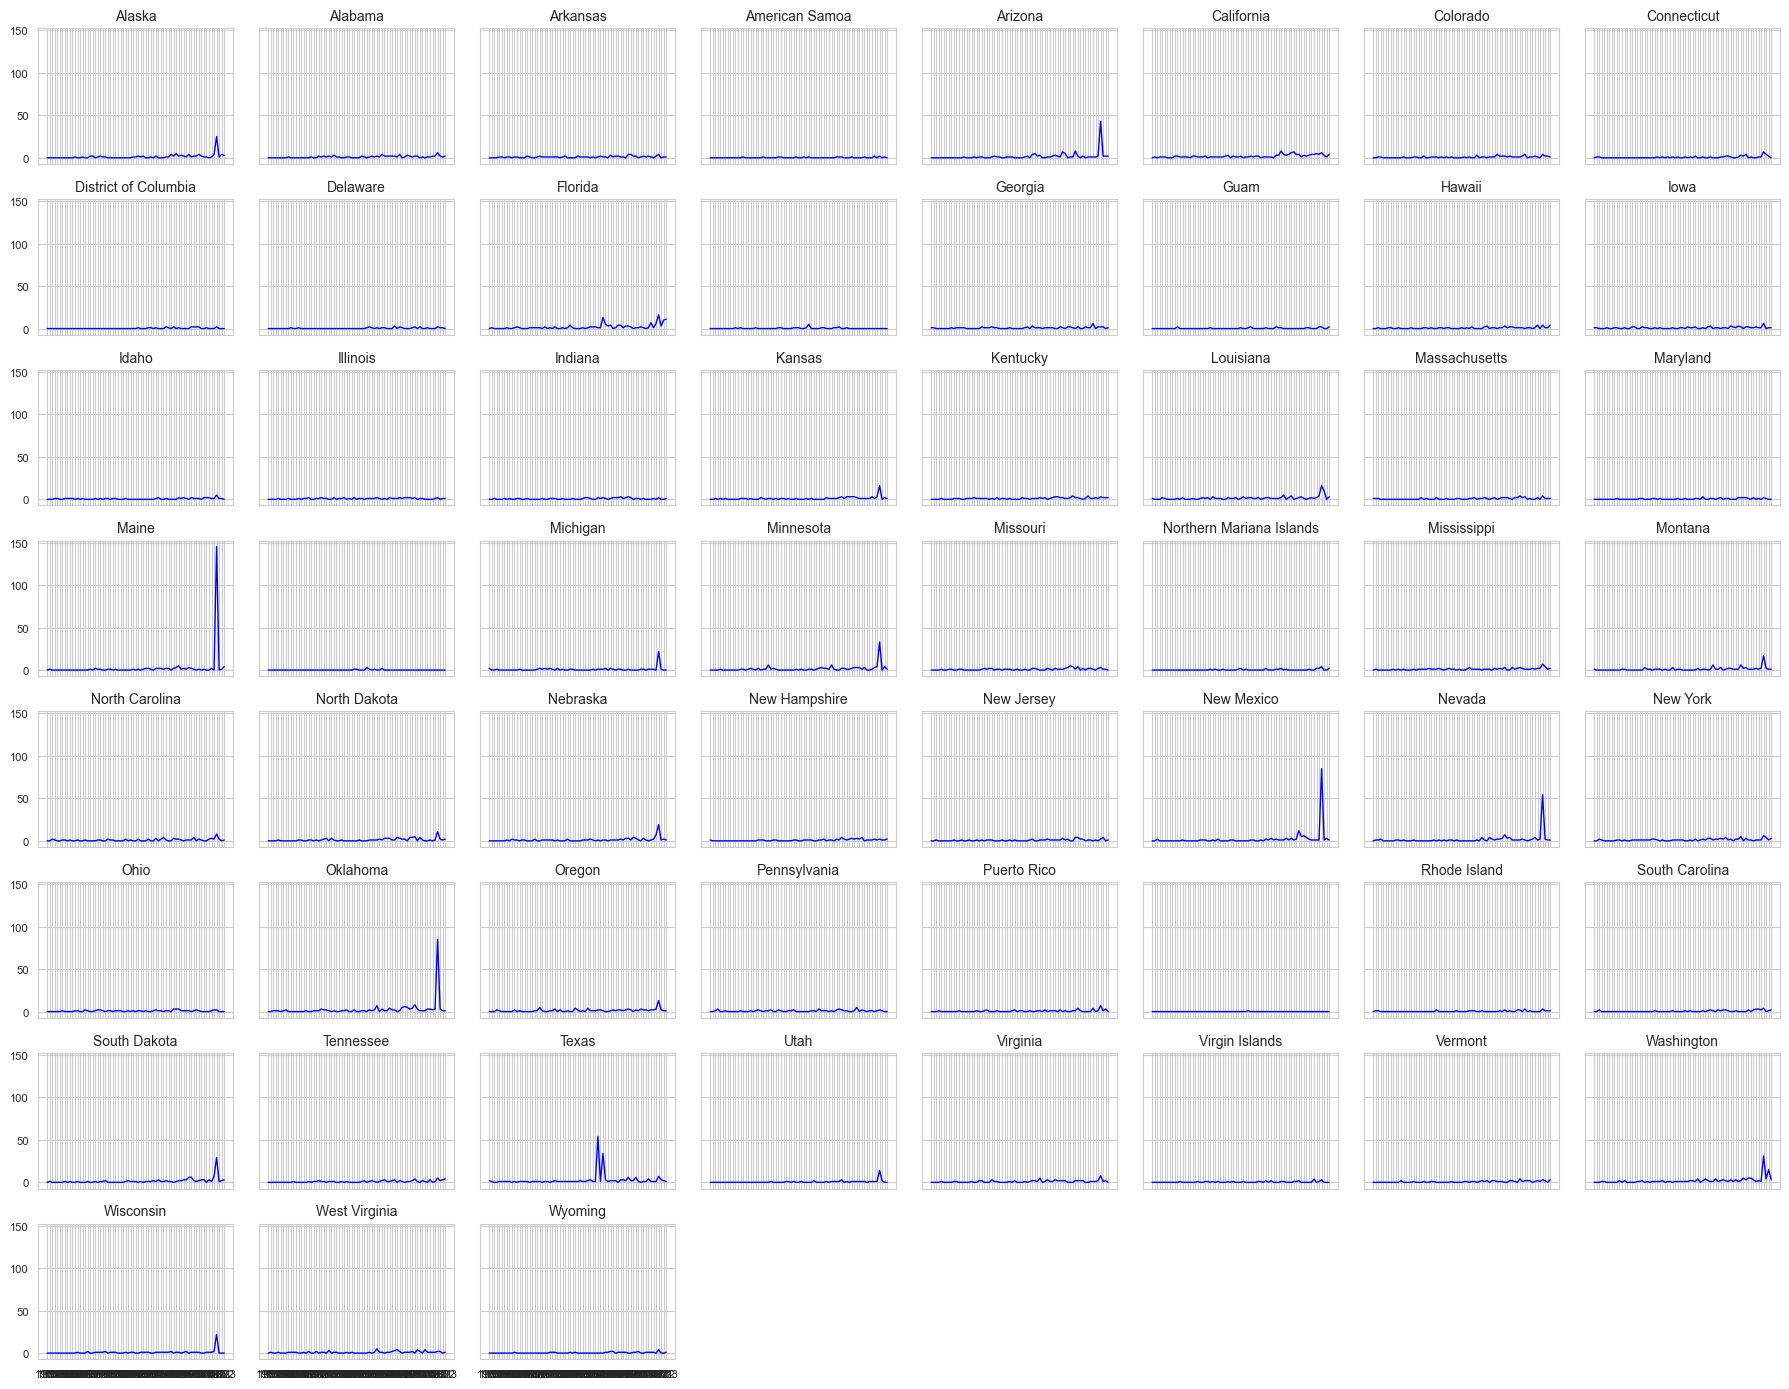

In [11]:
import usa
# Set the aesthetic style of the plots
sns.set_style("whitegrid")
# List of state codes to be used for plot titles
state_codes = state_yearly_disasters_transposed.columns[1:]
# Number of rows and columns for the grid plot
n_rows = 8
n_cols = 8
# Create a figure for the grid plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 14), sharex=True, sharey=True)
# Loop through each state and create a time series plot
for i, state_code in enumerate(state_codes):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    sns.lineplot(x='Year', y=state_code, data=state_yearly_disasters_transposed, ax=ax, color='b', linewidth=1)
    ax.set_title(usa.state_abbreviation_to_name(state_code), fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=8)
# Remove empty subplots
for i in range(len(state_codes), n_rows*n_cols):
    fig.delaxes(axes.flatten()[i])
# Adjust the layout
plt.tight_layout()
# Display the grid plot
plt.show()

Check ME peak

In [12]:
#Analyze Maine in fema_disasters dataset, find the most common incident type
#Create dataset with only Maine
fema_disasters_ME = fema_disasters[fema_disasters['state'] == 'ME']
#display(fema_disasters_ME)
#Group by incident type and count the number of disasters
fema_disasters_ME_sum = fema_disasters_ME.groupby('incidentType').size().reset_index(name='Disasters')
#Sort by number of disasters
fema_disasters_ME_sum = fema_disasters_ME_sum.sort_values(by='Disasters', ascending=False)
display(fema_disasters_ME_sum)


,incidentType,Disasters
6,Severe Storm,147
3,Flood,106
7,Snowstorm,81
5,Hurricane,50
2,Fishing Losses,16
4,Freezing,11
0,Coastal Storm,9
1,Fire,2


## Create Map Plot for 2022

In [13]:
import geopandas as gpd

# Filtering the row for the year 2022
disasters_2022 = state_yearly_disasters_transposed[state_yearly_disasters_transposed['Year'] == '2022']

# Melting the data to get the total number of disasters for each state in 2022
disasters_2022 = disasters_2022.melt(id_vars=['Year'], var_name='State', value_name='Disasters_2022')

# Convert the Disasters_2022 column to numeric
disasters_2022['Disasters_2022'] = pd.to_numeric(disasters_2022['Disasters_2022'])

# Display the data
disasters_2022.head()
#Save CSV file
#disasters_2022.to_csv('disasters_2022.csv')


,Year,State,Disasters_2022
0,2022,AK,4.0
1,2022,AL,1.0
2,2022,AR,1.0
3,2022,AS,1.0
4,2022,AZ,2.0


/Users/yannickpichardo/.pyenv/versions/3.11.1/lib/python3.11/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


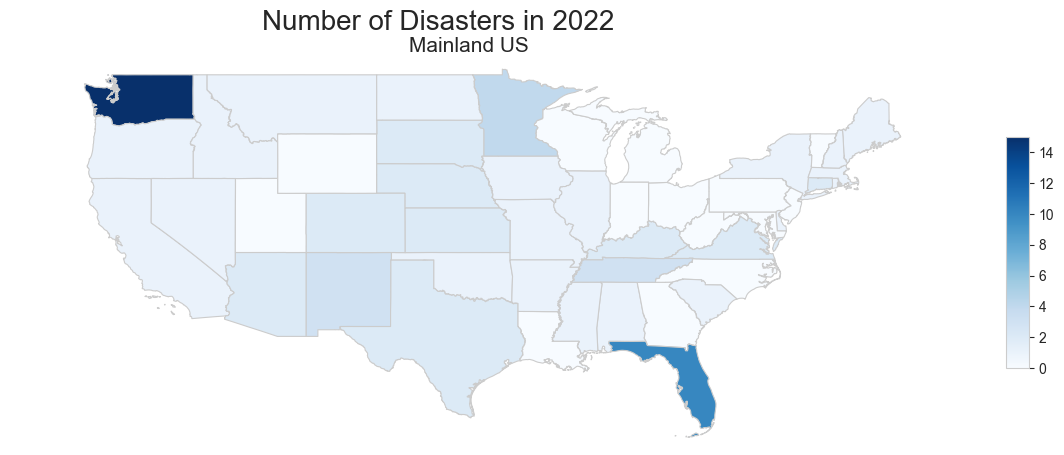

In [14]:
shapefile_path = "../shapefile/usa/cb_2018_us_state_5m.shp"
us_shapefile = gpd.read_file(shapefile_path)
# Merge the disaster data with the shapefile data
us_shapefile = us_shapefile.merge(disasters_2022, left_on='STUSPS', right_on='State', how='left')

# Create separate plots for Alaska and Hawaii
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
#Remove all ax spines

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Mainland US
us_shapefile[us_shapefile['STUSPS'] != 'HI'][us_shapefile['STUSPS'] != 'AK'].plot(column='Disasters_2022', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.6, 'aspect': 10})
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.set_title('Mainland US', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# # Alaska
# us_shapefile[us_shapefile['STUSPS'] == 'AK'].plot(column='Disasters_2022', cmap='Blues', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.6, 'aspect': 10})
# ax[1].set_title('Alaska', fontdict={'fontsize': '15', 'fontweight' : '3'})
# ax[1].set_xlim([-200, -100])
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# ax[1].grid(False)

# # Hawaii
# us_shapefile[us_shapefile['STUSPS'] == 'HI'].plot(column='Disasters_2022', cmap='Blues', linewidth=0.8, ax=ax[2], edgecolor='0.8', legend=True, legend_kwds={'shrink': 0.6, 'aspect': 10})
# ax[2].set_title('Hawaii', fontdict={'fontsize': '15', 'fontweight' : '3'})
# ax[2].set_xticks([])
# ax[2].set_yticks([])
# ax[2].grid(False)

# Set the main title
plt.suptitle('Number of Disasters in 2022', fontsize=20)

# Display the plots
plt.show()


# Hurricane Risk Score Index

In [15]:
#Load the shapefile
shapefile_path = "../shapefile/NRI_Shapefile_Counties/NRI_Shapefile_Counties.shp"
print('loading')
gdf = gpd.read_file(shapefile_path)
print('loaded')
#Filter the data to exclude Alaska and the islands
mainland_usa_gdf = gdf[
    (gdf['STATE'] != 'Alaska') & 
    (gdf['STATE'] != 'Hawaii') & 
    (gdf['STATE'] != 'Puerto Rico') & 
    (gdf['STATE'] != 'Guam') & 
    (gdf['STATE'] != 'American Samoa') & 
    (gdf['STATE'] != 'Northern Mariana Islands') & 
    (gdf['STATE'] != 'Virgin Islands')
].copy()

#mainland_usa_gdf.loc[:, 'HRCN_RISKS'].replace(-9999, np.nan, inplace=True)
mainland_usa_gdf = mainland_usa_gdf[mainland_usa_gdf['HRCN_RISKS'] != -9999]
#Takes around 1:40 to run


loading
loaded


In [16]:
#Save shapefile
#mainland_usa_gdf.to_file('../shapefile/mainland_usa_gdf.shp')

## Plot Hurricane Risk

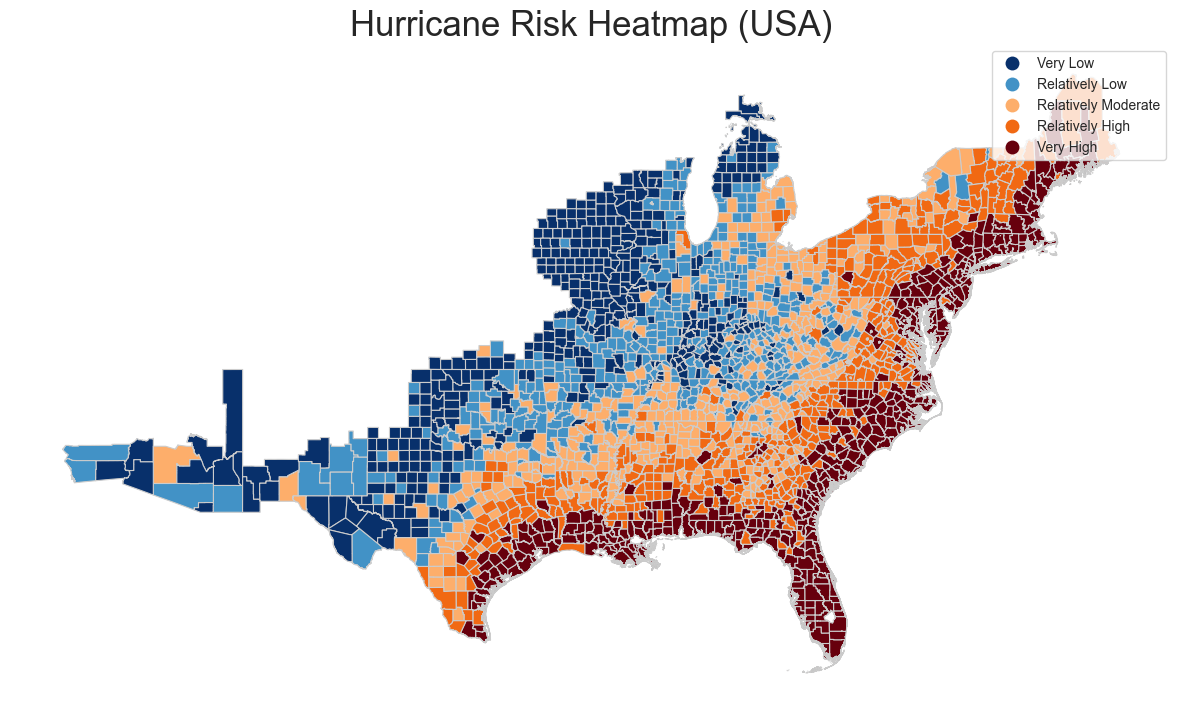

In [17]:
#Load csv mainland_usa_gdf_HRCN
mainland_usa_gdf = gpd.read_file('../shapefile/mainland_usa_gdf.shp')
#5 bins based on quantiles to categorize the scores into 5 distinct sections
mainland_usa_gdf['HRCN_RISK_CATEGORY_QUANTILE'] = pd.qcut(mainland_usa_gdf['HRCN_EALS'], q=5, labels=['Very Low', "Relatively Low", 'Relatively Moderate', 'Relatively High', 'Very High'])
colors = ['#08306b', '#4292c6', '#fdae6b', '#f16913', '#67000d']
custom_cmap = ListedColormap(colors) # type: ignore
#Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 25))
plt.grid(False)
mainland_usa_gdf.plot(column='HRCN_RISK_CATEGORY_QUANTILE', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Hurricane Risk Heatmap (USA)', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Remove all axis values
ax.set_xticks([])
ax.set_yticks([])
#Remove all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Display the map
#Save plot heatmap
plt.savefig('../Plots/hurricane_risk_heatmap.png')
plt.show()
#Takes around 2

In [18]:
#show columns that have HRCN in mainland_usa_gdf
display(mainland_usa_gdf.columns[mainland_usa_gdf.columns.str.contains('HRCN')])
#Save mainland_usa_gdf_HRCN file which includes HRCN columns
hrcn_columns = [col for col in mainland_usa_gdf.columns if 'HRCN' in col]
selected_columns = ['STATE', 'COUNTY'] + hrcn_columns
mainland_usa_gdf_HRCN = mainland_usa_gdf[selected_columns]

Index(['HRCN_EVNTS', 'HRCN_AFREQ', 'HRCN_EXP_A', 'HRCN_EXPB', 'HRCN_EXPP',
       'HRCN_EXPPE', 'HRCN_EXPA', 'HRCN_EXPT', 'HRCN_HLRB', 'HRCN_HLRP',
       'HRCN_HLRA', 'HRCN_HLRR', 'HRCN_EALB', 'HRCN_EALP', 'HRCN_EALPE',
       'HRCN_EALA', 'HRCN_EALT', 'HRCN_EALS', 'HRCN_EALR', 'HRCN_ALRB',
       'HRCN_ALRP', 'HRCN_ALRA', 'HRCN_ALR_N', 'HRCN_RISKV', 'HRCN_RISKS',
       'HRCN_RISKR', 'HRCN_RISK_CATEGORY_QUANTILE'],
      dtype='object')

In [19]:
#Add state code to mainland_usa_gdf_HRCN using usa library
mainland_usa_gdf_HRCN.loc[:, 'STATE_CODE'] = mainland_usa_gdf_HRCN['STATE'].apply(lambda x: usa.state_name_to_abbreviation(x))
display(mainland_usa_gdf_HRCN.head())


/var/folders/c1/zsf9b64s44n17287k844v5v40000gn/T/ipykernel_8444/4133275099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainland_usa_gdf_HRCN.loc[:, 'STATE_CODE'] = mainland_usa_gdf_HRCN['STATE'].apply(lambda x: usa.state_name_to_abbreviation(x))


,STATE,COUNTY,HRCN_EVNTS,HRCN_AFREQ,HRCN_EXP_A,HRCN_EXPB,HRCN_EXPP,HRCN_EXPPE,HRCN_EXPA,HRCN_EXPT,...,HRCN_EALR,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR,HRCN_RISK_CATEGORY_QUANTILE,STATE_CODE
0,Alabama,Autauga,13.0,0.080450,610.470508,9.121108e+09,58748.668261,6.814846e+11,2.449691e+07,6.906302e+11,...,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High,AL
1,Alabama,Baldwin,50.0,0.248233,1674.843955,4.596806e+10,231362.821627,2.683809e+12,1.380755e+08,2.729915e+12,...,Relatively High,0.003778,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421,Relatively High,Very High,AL
2,Alabama,Barbour,21.0,0.116398,913.646511,4.847697e+09,25160.000000,2.918560e+11,1.210758e+08,2.968248e+11,...,Relatively Low,0.000315,7.186926e-08,0.003586,78.815391,3.079796e+06,77.164648,Relatively Low,Relatively High,AL
3,Alabama,Bibb,11.0,0.066724,632.486798,3.146947e+09,22239.000000,2.579724e+11,4.819356e+06,2.611242e+11,...,Very Low,0.000056,1.356953e-08,0.000507,59.446606,2.226110e+05,51.099148,Very Low,Relatively Moderate,AL
4,Alabama,Blount,6.0,0.039238,657.196555,7.815387e+09,58989.060165,6.842731e+11,2.776569e+08,6.923661e+11,...,Very Low,0.000024,4.874959e-09,0.000199,49.632512,3.010121e+05,54.015253,Very Low,Relatively Moderate,AL


# Mortgage Lending

In [20]:
#Read in data from CSV file
# hmda_dynamic_2022 = pd.read_csv('Data/hmda_dynamic_2022.csv')
#Keep activity_year, state_code, county_code, 

# Housing Price Index (HPI)

In [21]:
#Get unique state codes from mainland_usa_gdf_HRCN
state_codes = mainland_usa_gdf_HRCN['STATE_CODE'].unique()
state_codes

array(['AL', 'AZ', 'AR', 'CA', 'CT', 'DE', 'DC', 'FL', 'GA', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO',
       'NH', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'PA', 'RI', 'SC', 'TN',
       'TX', 'VT', 'VA', 'WV', 'WI'], dtype=object)

In [22]:
#load in HPI_AT_BDL_county.xlsx
hpi = pd.read_excel('../Data/HPI_AT_BDL_county.xlsx')
#Filter the data on the states in state_codes from the column State
hpi = hpi[hpi['State'].isin(state_codes)]
display(hpi.shape)


(83190, 8)

In [23]:
#save file HPI_county_hurricane.xlsx
#hpi.to_excel('../Data/HPI_county_hurricane.xlsx')

In [24]:
hpi.head()

,State,County,FIPS code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,AL,Autauga,1001,1986,.,100.00,94.92,70.22
1,AL,Autauga,1001,1987,-2.22,97.78,92.81,68.66
2,AL,Autauga,1001,1988,3.80,101.49,96.33,71.26
3,AL,Autauga,1001,1989,4.33,105.88,100.51,74.35
4,AL,Autauga,1001,1990,-0.51,105.35,100.00,73.97


## Merge HPI with hurricane risk data

,State,County,FIPS code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,STATE,COUNTY,...,HRCN_EALS,HRCN_EALR,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR,HRCN_RISK_CATEGORY_QUANTILE
0,AL,Autauga,1001,1986,.,100.00,94.92,70.22,Alabama,Autauga,...,66.364029,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High
1,AL,Autauga,1001,1987,-2.22,97.78,92.81,68.66,Alabama,Autauga,...,66.364029,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High
2,AL,Autauga,1001,1988,3.80,101.49,96.33,71.26,Alabama,Autauga,...,66.364029,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High
3,AL,Autauga,1001,1989,4.33,105.88,100.51,74.35,Alabama,Autauga,...,66.364029,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High
4,AL,Autauga,1001,1990,-0.51,105.35,100.00,73.97,Alabama,Autauga,...,66.364029,Relatively Low,0.000093,3.347523e-08,0.001901,64.677907,1.014608e+06,67.653656,Relatively Low,Relatively High


,State,County,FIPS code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,STATE,COUNTY,...,HRCN_EALS,HRCN_EALR,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR,HRCN_RISK_CATEGORY_QUANTILE
37,AL,Baldwin,1003,1977,.,100.00,69.65,42.02,Alabama,Baldwin,...,99.005620,Relatively High,0.003778,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421,Relatively High,Very High
38,AL,Baldwin,1003,1977,.,100.00,69.65,42.02,Georgia,Baldwin,...,65.715521,Relatively Low,0.000088,2.258447e-08,0.001705,63.510592,1.128259e+06,68.864962,Relatively Low,Relatively High
39,AL,Baldwin,1003,1978,0.80,100.80,70.21,42.36,Alabama,Baldwin,...,99.005620,Relatively High,0.003778,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421,Relatively High,Very High
40,AL,Baldwin,1003,1978,0.80,100.80,70.21,42.36,Georgia,Baldwin,...,65.715521,Relatively Low,0.000088,2.258447e-08,0.001705,63.510592,1.128259e+06,68.864962,Relatively Low,Relatively High
41,AL,Baldwin,1003,1979,3.99,104.83,73.01,44.05,Alabama,Baldwin,...,99.005620,Relatively High,0.003778,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421,Relatively High,Very High


,State,County,FIPS code,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base,STATE,COUNTY,...,HRCN_EALS,HRCN_EALR,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS,HRCN_RISKR,HRCN_RISK_CATEGORY_QUANTILE
2424,AL,Calhoun,1015,1977,.,100.00,60.53,45.73,Alabama,Calhoun,...,67.920450,Relatively Low,4.310916e-05,1.181275e-08,0.000585,56.636403,1.271869e+06,69.896815,Relatively Low,Relatively High
2425,AL,Calhoun,1015,1977,.,100.00,60.53,45.73,Arkansas,Calhoun,...,30.912235,Very Low,3.894288e-05,7.854596e-09,0.000716,55.598789,5.816678e+04,33.781965,Very Low,Relatively Low
2426,AL,Calhoun,1015,1977,.,100.00,60.53,45.73,Florida,Calhoun,...,82.101167,Relatively Low,2.220968e-03,5.170804e-07,0.010132,91.569390,7.519952e+06,85.150292,Relatively Low,Very High
2427,AL,Calhoun,1015,1977,.,100.00,60.53,45.73,Georgia,Calhoun,...,67.444877,Relatively Low,5.341487e-04,1.199854e-07,0.005283,83.484652,1.583309e+06,72.139973,Relatively Low,Relatively High
2428,AL,Calhoun,1015,1977,.,100.00,60.53,45.73,Illinois,Calhoun,...,0.389105,Very Low,6.312253e-07,5.169600e-11,0.000005,5.317769,6.271850e+02,0.358905,Very Low,Very Low


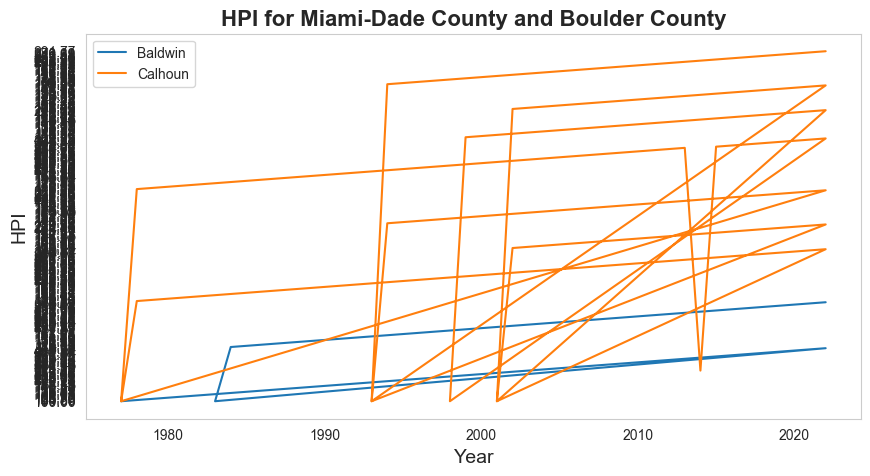

In [25]:
#Merge hpi and mainland_usa_gdf_HRCN on County
hpi_and_HRCN_data = hpi.merge(mainland_usa_gdf_HRCN, left_on='County', right_on='COUNTY')
#Drop STATE_CODE column
hpi_and_HRCN_data = hpi_and_HRCN_data.drop(columns='STATE_CODE')
display(hpi_and_HRCN_data.head())

#extract hpi for 2 counties, 1 for Very High HRCN_RISK_CATEGORY_QUANTILE and another from very low HRCN_RISK_CATEGORY_QUANTILE
#Select one county
hpi_and_HRCN_data_very_high = hpi_and_HRCN_data[hpi_and_HRCN_data['County'] == 'Baldwin']
display(hpi_and_HRCN_data_very_high.head())

hpi_and_HRCN_data_very_low = hpi_and_HRCN_data[hpi_and_HRCN_data['County'] == 'Calhoun']
#Select one county
#hpi_and_HRCN_data_very_low = hpi_and_HRCN_data_very_low[hpi_and_HRCN_data_very_low['COUNTY'] == 'Butler']
display(hpi_and_HRCN_data_very_low.head())
#Plot the difference of HPI for the two counties
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.grid(False)
#Plot the HPI for the very high risk county
plt.plot(hpi_and_HRCN_data_very_high['Year'], hpi_and_HRCN_data_very_high['HPI'], label='Baldwin')
#Plot the HPI for the very low risk county
plt.plot(hpi_and_HRCN_data_very_low['Year'], hpi_and_HRCN_data_very_low['HPI'], label='Calhoun')
#Create legend
plt.legend()
#Create title
plt.title('HPI for Miami-Dade County and Boulder County', fontsize=16, fontweight='bold')
#Create x and y labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('HPI', fontsize=14)
#Save plot
#plt.savefig('../Plots/HPI_Miami_Dade_Boulder.png')
plt.show()


# Atlantic Hurricane Dataset from 1979
https://www.nhc.noaa.gov/data/#hurdat

In [26]:
#Import data from url
hurricane_data = []
with open("../Data/nhc.noaa.gov_data_hurdat_hurdat2-1851-2020-052921.txt", "r") as f:
    lines = f.readlines()
    storm_data = None
    for line in lines:
        parts = line.split(",")
        
        if len(parts) == 4 and int(parts[0][-4:]) >= 1979:  # Header Line
            #Get last 4 digits from first entry
            storm_data = {"id": parts[0].strip(), "name": parts[1].strip(), "entries": int(parts[2]), "year": int(parts[0][-4:])}
        else:  # Data Line
            hurricane_data.append({**storm_data, **{
                "date": parts[0].strip(),
                "time": parts[1].strip(),
                "record_id": parts[2].strip(),
                "status": parts[3].strip(),
                "latitude": parts[4].strip(),
                "longitude": parts[5].strip(),
                "max_wind": int(parts[6].strip()),
                "min_pressure": int(parts[7].strip()) if parts[12].strip() != "" else None
            }})

# Create DataFrame from parsed data
hurricane_df = pd.DataFrame(hurricane_data)
#convert date to datetime format
hurricane_df['date'] = pd.to_datetime(hurricane_df['date'], format='%Y%m%d')
#add month column to hurrican_df
hurricane_df['month'] = hurricane_df['date'].dt.month
#Save as csv
#hurricane_df.to_csv('../Data/hurricane_df.csv')

#describe data and make entries column the unique count of id
display(hurricane_df.describe())
display(hurricane_df)


,entries,year,date,max_wind,min_pressure,month
count,19180.000000,19180.000000,19180,19180.000000,19180.000000,19180.000000
mean,40.353910,2001.466632,2002-02-23 12:13:21.835245184,48.399791,881.660740,8.678311
min,2.000000,1979.000000,1979-06-11 00:00:00,-99.000000,-999.000000,1.000000
25%,24.000000,1991.000000,1991-10-30 00:00:00,30.000000,982.000000,8.000000
50%,38.000000,2003.000000,2003-08-27 12:00:00,40.000000,999.000000,9.000000
75%,55.000000,2012.000000,2012-05-26 00:00:00,60.000000,1006.000000,9.000000
max,96.000000,2020.000000,2020-11-18 00:00:00,165.000000,1024.000000,12.000000
std,20.312358,12.104994,NaN,25.734435,459.088771,1.400565


,id,name,entries,year,date,time,record_id,status,latitude,longitude,max_wind,min_pressure,month
0,AL011979,UNNAMED,22,1979,1979-06-11,1200,,TD,17.4N,81.1W,20,-999,6
1,AL011979,UNNAMED,22,1979,1979-06-11,1800,,TD,17.7N,80.8W,25,-999,6
2,AL011979,UNNAMED,22,1979,1979-06-12,0000,,TD,18.1N,80.2W,25,-999,6
3,AL011979,UNNAMED,22,1979,1979-06-12,0600,,TD,18.4N,79.9W,25,-999,6
4,AL011979,UNNAMED,22,1979,1979-06-12,1200,,TD,19.0N,79.6W,25,-999,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19175,AL312020,IOTA,26,2020,2020-11-17,1200,,HU,13.7N,84.7W,75,965,11
19176,AL312020,IOTA,26,2020,2020-11-17,1800,,TS,13.7N,85.7W,55,988,11
19177,AL312020,IOTA,26,2020,2020-11-18,0000,,TS,13.8N,86.7W,40,1000,11
19178,AL312020,IOTA,26,2020,2020-11-18,0600,,TS,13.8N,87.8W,35,1005,11


In [27]:
hurricane_df_agg = hurricane_df.groupby(['year', 'month']).agg({'id': 'nunique', 'max_wind': 'median', 'min_pressure': 'median', 'status': 'count'}).reset_index()
display(hurricane_df_agg.head())

#Convert enso_mei_long Month column to number of month
enso_mei_long['Month Num'] = pd.to_datetime(enso_mei_long['Month'], format='%b').dt.month


#Merge hurricane_df_agg to enso_mei_long on year and month
hurricane_df_agg_merge = hurricane_df_agg.merge(enso_mei_long, left_on=['year', 'month'], right_on=['Year', 'Month Num'])
#Create binary column for El Nino and La Nina
hurricane_df_agg_merge['El Nino'] = np.where(hurricane_df_agg_merge['MEI'] >= 1, 1, 0)
hurricane_df_agg_merge['La Nina'] = np.where(hurricane_df_agg_merge['MEI'] <= -1, 1, 0)
hurricane_df_agg_merge['El Nino light'] = np.where((hurricane_df_agg_merge['MEI'] >= 0.5) & (hurricane_df_agg_merge['MEI'] < 1), 1, 0)
hurricane_df_agg_merge['La Nina light'] = np.where((hurricane_df_agg_merge['MEI'] <= -0.5) & (hurricane_df_agg_merge['MEI'] > -1), 1, 0)
display(hurricane_df_agg_merge)
#display(hurricane_df_agg_merge.head())
#Save aggregated hurricane data
hurricane_df_agg_merge.to_csv('../Data/hurricane_df_agg_merge.csv')

,year,month,id,max_wind,min_pressure,status
0,1979,6,2,30.0,-999.0,41
1,1979,7,6,25.0,1003.0,137
2,1979,8,5,30.0,927.0,81
3,1979,9,7,40.0,990.0,216
4,1979,10,3,25.0,-999.0,63


,year,month,id,max_wind,min_pressure,status,Year,Month,MEI,Date,Month Num,El Nino,La Nina,El Nino light,La Nina light
0,1979,6,2,30.0,-999.0,41,1979,Jun,-0.14,1979-06-01,6,0,0,0,0
1,1979,7,6,25.0,1003.0,137,1979,Jul,-0.13,1979-07-01,7,0,0,0,0
2,1979,8,5,30.0,927.0,81,1979,Aug,0.50,1979-08-01,8,0,0,1,0
3,1979,9,7,40.0,990.0,216,1979,Sep,0.42,1979-09-01,9,0,0,0,0
4,1979,10,3,25.0,-999.0,63,1979,Oct,0.28,1979-10-01,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2020,7,6,35.0,1006.0,115,2020,Jul,-0.88,2020-07-01,7,0,0,0,1
245,2020,8,7,40.0,1004.0,124,2020,Aug,-0.94,2020-08-01,8,0,0,0,1
246,2020,9,10,35.0,1003.0,327,2020,Sep,-1.21,2020-09-01,9,0,1,0,0
247,2020,10,5,55.0,990.0,119,2020,Oct,-1.19,2020-10-01,10,0,1,0,0


### Simple correlation

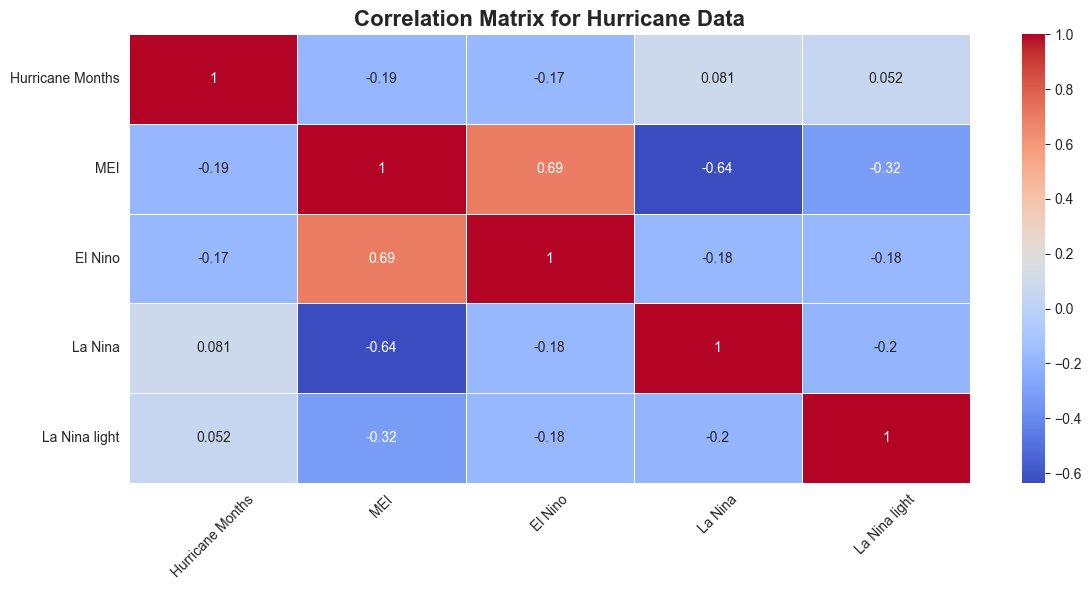

In [29]:
# Compute the correlation matrix
#change id to Hurricane Months
hurricane_df_agg_merge = hurricane_df_agg_merge.rename(columns={'id': 'Hurricane Months'})
correlation_matrix_agg = hurricane_df_agg_merge[['Hurricane Months', 'MEI', 'El Nino', 'La Nina', 'La Nina light']].corr()

correlation_matrix_agg
#Create correlation heatmap with seaborn with ID on the rows renamed as Hurricane Monts, and MEI, El Nino and La Nina on the columns
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_agg, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Hurricane Data', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#Save plot in Plots folder with full quality
plt.savefig('../Plots/correlation_matrix_agg.png', dpi=300)
plt.show()





### Simple OLS Regression analysis on N hurricane MOnths

In [30]:
import statsmodels.api as sm

# Setting up the independent variable (MEI) and dependent variable (number of hurricanes)
X = hurricane_df_agg_merge["MEI"]
y = hurricane_df_agg_merge["Hurricane Months"]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Running the regression model
model = sm.OLS(y, X).fit()

# Getting the summary of the regression
regression_summary = model.summary()
for table in regression_summary.tables:
    print(table.as_latex_tabular())
regression_summary

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & Hurricane Months & \textbf{  R-squared:         } &    0.034  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.030  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    8.796  \\
\textbf{Date:}             & Sat, 30 Sep 2023 & \textbf{  Prob (F-statistic):} & 0.00331   \\
\textbf{Time:}             &     20:14:04     & \textbf{  Log-Likelihood:    } &  -562.86  \\
\textbf{No. Observations:} &         249      & \textbf{  AIC:               } &    1130.  \\
\textbf{Df Residuals:}     &         247      & \textbf{  BIC:               } &    1137.  \\
\textbf{Df Model:}         &           1      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Hurricane Months   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.796
Date:                Sat, 30 Sep 2023   Prob (F-statistic):            0.00331
Time:                        20:14:04   Log-Likelihood:                -562.86
No. Observations:                 249   AIC:                             1130.
Df Residuals:                     247   BIC:                             1137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2464      0.148     21.938      0.000       2.955       3.538
MEI           -0.4619      0.156     -2.966      0.003      -0.769      -0.155
==============================================================================
Omnibus:                       30.037   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.822
Skew:                           0.950   Prob(JB):                     6.12e-09
Kurtosis:                       3.193   Cond. No.                         1.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#Aggregate hurricane_df by status only counting HU
hurricane_data_agg_HU = hurricane_df[hurricane_df['status'] == 'HU'].groupby(['year', 'month']).agg({'id': 'nunique', 'max_wind': 'median', 'min_pressure': 'median', 'status': 'count'}).reset_index()
display(hurricane_data_agg_HU.head())

#Convert enso_mei_long Month column to number of month
enso_mei_long['Month Num'] = pd.to_datetime(enso_mei_long['Month'], format='%b').dt.month


#Merge hurricane_df_agg to enso_mei_long on year and month
hurricane_df_agg_HU_merge = hurricane_data_agg_HU.merge(enso_mei_long, left_on=['year', 'month'], right_on=['Year', 'Month Num'])
#Create binary column for El Nino and La Nina
hurricane_df_agg_HU_merge['El Nino'] = np.where(hurricane_df_agg_HU_merge['MEI'] >= 1, 1, 0)
hurricane_df_agg_HU_merge['La Nina'] = np.where(hurricane_df_agg_HU_merge['MEI'] <= -1, 1, 0)
hurricane_df_agg_HU_merge['El Nino light'] = np.where((hurricane_df_agg_HU_merge['MEI'] >= 0.5) & (hurricane_df_agg_HU_merge['MEI'] < 1), 1, 0)
hurricane_df_agg_HU_merge['La Nina light'] = np.where((hurricane_df_agg_HU_merge['MEI'] <= -0.5) & (hurricane_df_agg_HU_merge['MEI'] > -1), 1, 0)
#Add neutral phase
hurricane_df_agg_HU_merge['Neutral'] = np.where((hurricane_df_agg_HU_merge['MEI'] > -0.5) & (hurricane_df_agg_HU_merge['MEI'] < 0.5), 1, 0)
display(hurricane_df_agg_HU_merge)
#display(hurricane_df_agg_merge.head())

,year,month,id,max_wind,min_pressure,status
0,1979,7,1,65.0,988.0,3
1,1979,8,1,125.0,938.0,19
2,1979,9,4,75.0,984.0,64
3,1980,8,3,97.5,960.0,52
4,1980,9,3,80.0,970.0,62


,year,month,id,max_wind,min_pressure,status,Year,Month,MEI,Date,Month Num,El Nino,La Nina,El Nino light,La Nina light,Neutral
0,1979,7,1,65.0,988.0,3,1979,Jul,-0.13,1979-07-01,7,0,0,0,0,1
1,1979,8,1,125.0,938.0,19,1979,Aug,0.50,1979-08-01,8,0,0,1,0,0
2,1979,9,4,75.0,984.0,64,1979,Sep,0.42,1979-09-01,9,0,0,0,0,1
3,1980,8,3,97.5,960.0,52,1980,Aug,0.13,1980-08-01,8,0,0,0,0,1
4,1980,9,3,80.0,970.0,62,1980,Sep,0.19,1980-09-01,9,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2020,7,2,70.0,985.5,10,2020,Jul,-0.88,2020-07-01,7,0,0,0,1,0
144,2020,8,3,75.0,986.5,18,2020,Aug,-0.94,2020-08-01,8,0,0,0,1,0
145,2020,9,4,85.0,965.5,56,2020,Sep,-1.21,2020-09-01,9,0,1,0,0,0
146,2020,10,4,75.0,968.0,50,2020,Oct,-1.19,2020-10-01,10,0,1,0,0,0


In [57]:
# Compute the correlation matrix


correlation_matrix_agg = hurricane_df_agg_merge[['MEI', 'Hurricane Months', 'max_wind', 'min_pressure', 'El Nino', 'La Nina', 'El Nino light', 'La Nina light']].corr()

correlation_matrix_agg


,MEI,Hurricane Months,max_wind,min_pressure,El Nino,La Nina,El Nino light,La Nina light
MEI,1.000000,-0.185438,-0.161436,-0.040835,0.694286,-0.635325,0.288818,-0.315728
Hurricane Months,-0.185438,1.000000,0.206548,0.151749,-0.170529,0.080903,0.012067,0.051612
max_wind,-0.161436,0.206548,1.000000,0.354864,-0.103111,0.136167,-0.076233,0.004148
min_pressure,-0.040835,0.151749,0.354864,1.000000,0.032161,0.051416,-0.128622,-0.025751
El Nino,0.694286,-0.170529,-0.103111,0.032161,1.000000,-0.176555,-0.141548,-0.179126
La Nina,-0.635325,0.080903,0.136167,0.051416,-0.176555,1.000000,-0.158031,-0.199986
El Nino light,0.288818,0.012067,-0.076233,-0.128622,-0.141548,-0.158031,1.000000,-0.160333
La Nina light,-0.315728,0.051612,0.004148,-0.025751,-0.179126,-0.199986,-0.160333,1.000000


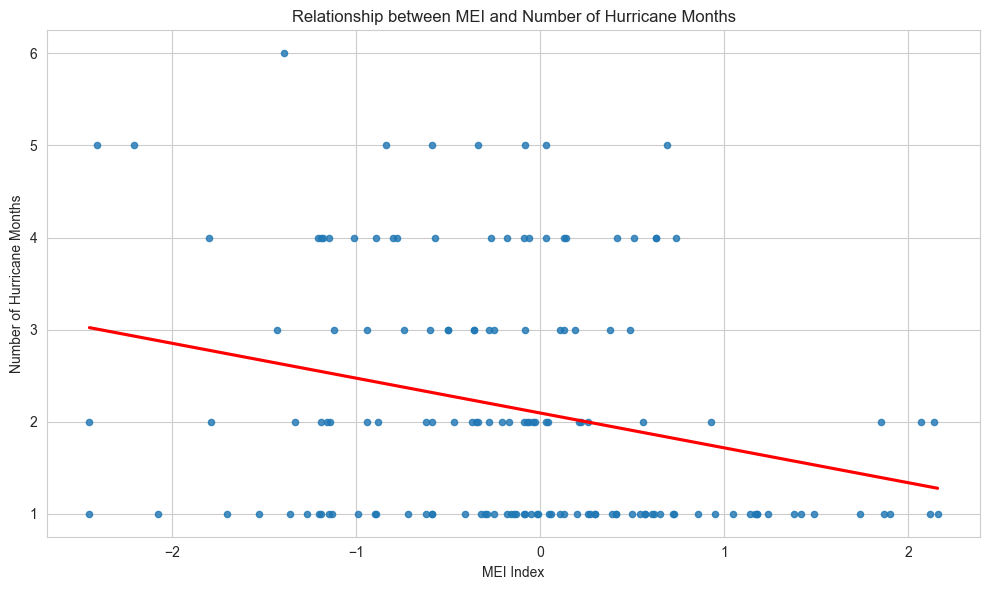

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     id   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     11.65
Date:                Tue, 26 Sep 2023   Prob (F-statistic):           0.000832
Time:                        11:36:28   Log-Likelihood:                -245.45
No. Observations:                 148   AIC:                             494.9
Df Residuals:                     146   BIC:                             500.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0939      0.106     19.737      0.000       1.884       2.304
MEI           -0.3785      0.111     -3.413      0.001      -0.598      -0.159
==============================================================================
Omnibus:                       13.856   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.736
Skew:                           0.734   Prob(JB):                     0.000631
Kurtosis:                       2.517   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Setting up the independent variable (MEI) and dependent variable (number of hurricanes)
X = hurricane_df_agg_HU_merge["MEI"]
y = hurricane_df_agg_HU_merge["id"]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Running the regression model
model = sm.OLS(y, X).fit()

# Getting the summary of the regression
regression_summary = model.summary()


# Plotting the relationship between MEI and number of hurricanes
plt.figure(figsize=(10, 6))
sns.regplot(x="MEI", y="id", data=hurricane_df_agg_HU_merge, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)
plt.title("Relationship between MEI and Number of Hurricane Months")
plt.xlabel("MEI Index")
plt.ylabel("Number of Hurricane Months")
plt.grid(True)
plt.tight_layout()
plt.show()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     id   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     20.32
Date:                Sat, 30 Sep 2023   Prob (F-statistic):           5.61e-05
Time:                        20:42:23   Log-Likelihood:                -105.23
No. Observations:                  42   AIC:                             214.5
Df Residuals:                      40   BIC:                             217.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5090      0.469     16.020      0.000       6.562       8.456
MEI           -2.3023      0.511     -4.507      0.000      -3.335      -1.270
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.055
Skew:                           0.072   Prob(JB):                        0.973
Kurtosis:                       2.897   Cond. No.                         1.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

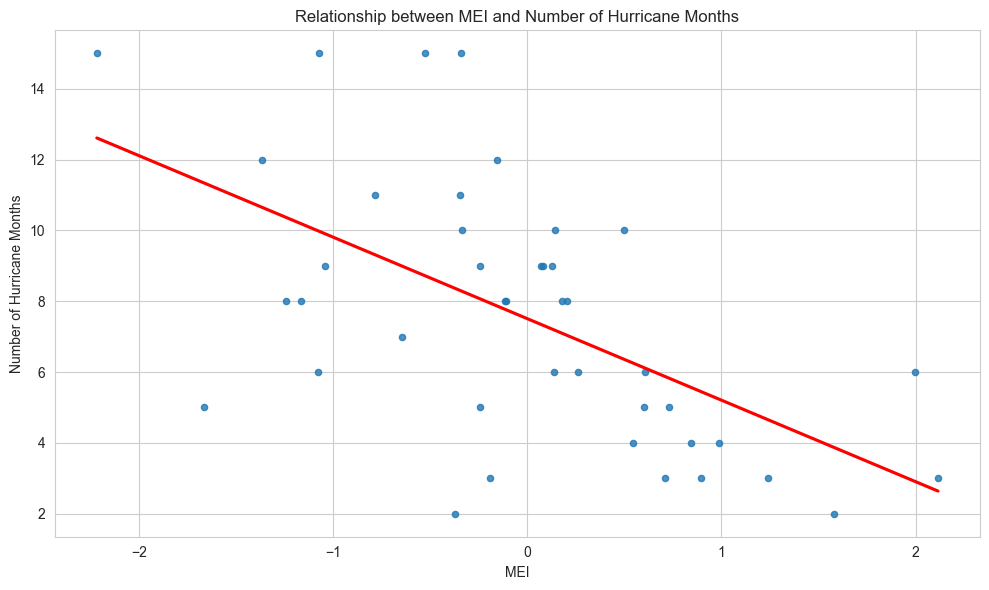

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        id        & \textbf{  R-squared:         } &    0.337  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.320  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    20.32  \\
\textbf{Date:}             & Sat, 30 Sep 2023 & \textbf{  Prob (F-statistic):} & 5.61e-05  \\
\textbf{Time:}             &     20:42:23     & \textbf{  Log-Likelihood:    } &  -105.23  \\
\textbf{No. Observations:} &          42      & \textbf{  AIC:               } &    214.5  \\
\textbf{Df Residuals:}     &          40      & \textbf{  BIC:               } &    217.9  \\
\textbf{Df Model:}         &           1      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

In [78]:
# Setting up the independent variable (MEI) and dependent variable (number of hurricanes)
#Add El Nino, La Nina, El Nino Light and La Nina light to X 
#Group by year and sum id
hurricane_df_agg_HU_merge_new = hurricane_df_agg_HU_merge.groupby('Year').agg({
    'id': 'sum',
    'MEI': 'mean',
    'La Nina': 'max',
    'Neutral': 'max',
    'La Nina light': 'max'
}).reset_index()

X = hurricane_df_agg_HU_merge_new[["MEI"]]

y = hurricane_df_agg_HU_merge_new["id"]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Running the regression model
model = sm.OLS(y, X).fit()
# Getting the summary of the regression
regression_summary = model.summary()
# for table in regression_summary.tables:
#     print(table.as_latex_tabular())
display(regression_summary)
# Plotting the relationship between MEI and number of hurricanes
plt.figure(figsize=(10, 6))
sns.regplot(x="MEI", y="id", data=hurricane_df_agg_HU_merge_new, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)
plt.title("Relationship between MEI and Number of Hurricane Months")
plt.xlabel("MEI")
plt.ylabel("Number of Hurricane Months")
plt.grid(True)
plt.tight_layout()
plt.show()

for table in regression_summary.tables:
    print(table.as_latex_tabular())

In [40]:
mean_hurricane = hurricane_df_agg_HU_merge["id"].mean()
var_hurricane = hurricane_df_agg_HU_merge["id"].var()

ratio = var_hurricane / mean_hurricane
print(ratio)


0.8194811047447368


In [75]:
# Use Poisson regression
X = hurricane_df_agg_HU_merge_new[["MEI"]]
y = hurricane_df_agg_HU_merge_new["id"]

model = sm.GLM(y, sm.add_constant(X), family=sm.families.Poisson())

results = model.fit()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                     id   No. Observations:                   42
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -103.75
Date:                Sat, 30 Sep 2023   Deviance:                       49.721
Time:                        20:39:42   Pearson chi2:                     47.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.4486
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9764      0.059     33.695      0.0

None

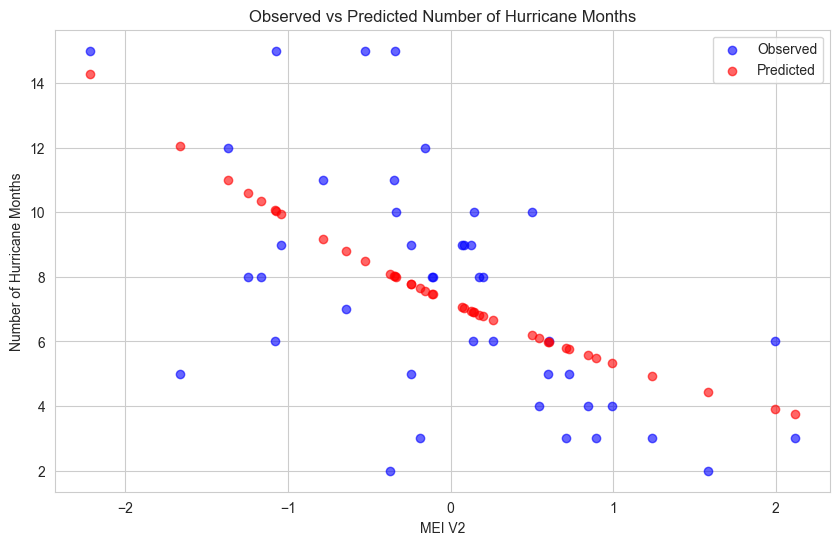

In [76]:
display(print(results.summary()))
df = hurricane_df_agg_HU_merge_new.copy()
# Predict the values
df['predicted'] = results.predict(sm.add_constant(X))

# Plot observed vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df['MEI'], df['id'], color='blue', label='Observed', alpha=0.6)
plt.scatter(df['MEI'], df['predicted'], color='red', label='Predicted', alpha=0.6)
plt.xlabel('MEI V2')
plt.ylabel('Number of Hurricane Months')
plt.title('Observed vs Predicted Number of Hurricane Months')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
import pandas as pd
from linearmodels import PanelOLS, RandomEffects

# Sample Data
# Assuming 'county' and 'time' are identifiers for the panel structure
# e.g. final_data = pd.read_csv('your_data.csv').set_index(['county', 'time'])

# Parameters for the mock dataset
num_counties = 5
num_time_points = 10

# Create mock data
np.random.seed(42)  # for reproducibility
counties = ['County_' + str(i) for i in range(1, num_counties + 1)]
time_points = list(range(1, num_time_points + 1))

# Create MultiIndex
multi_index = pd.MultiIndex.from_product([counties, time_points], names=['county', 'time'])

# Generate mock data for HPI, HRI, and ENSO
HPI = np.random.rand(num_counties * num_time_points) * 100 + 100  # HPI values between 100 and 200
HRI = np.random.rand(num_counties * num_time_points)  # HRI values between 0 and 1
ENSO = np.random.choice([-1, 0, 1], size=num_counties * num_time_points)  # ENSO values as -1, 0, or 1

final_data_mock = pd.DataFrame({'HPI': HPI, 'HRI': HRI, 'ENSO': ENSO}, index=multi_index)


# Create the interaction term
final_data_mock['HRI_ENSO'] = final_data_mock['HRI'] * final_data_mock['ENSO']

# Model without fixed/random effects
exog_vars = ['HRI', 'HRI_ENSO']
exog = sm.add_constant(final_data_mock[exog_vars])
mod_pool = PanelOLS(final_data_mock.HPI, exog, entity_effects=False, time_effects=False)
res_pool = mod_pool.fit()

display("Pooled OLS Results:")
display(res_pool)

# Model with fixed effects
mod_fe = PanelOLS(final_data_mock.HPI, exog, entity_effects=True, time_effects=False)
res_fe = mod_fe.fit()

display("\nFixed Effects Results:")
display(res_fe)

# Model with random effects
mod_re = RandomEffects(final_data_mock.HPI, exog)
res_re = mod_re.fit()

display("\nRandom Effects Results:")
display(res_re)


'Pooled OLS Results:'

Dep. Variable:,HPI,R-squared:,0.0050
Estimator:,PanelOLS,R-squared (Between):,0.0700
No. Observations:,50,R-squared (Within):,0.0023
Date:,"Tue, Oct 03 2023",R-squared (Overall):,0.0050
Time:,17:19:48,Log-likelihood,-238.49
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.1172
Entities:,5,P-value,0.8897
Avg Obs:,10.0000,Distribution:,"F(2,47)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,0.1172


'\nFixed Effects Results:'

Dep. Variable:,HPI,R-squared:,0.0034
Estimator:,PanelOLS,R-squared (Between):,0.0164
No. Observations:,50,R-squared (Within):,0.0034
Date:,"Tue, Oct 03 2023",R-squared (Overall):,0.0039
Time:,17:19:48,Log-likelihood,-237.54
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.0734
Entities:,5,P-value,0.9294
Avg Obs:,10.0000,Distribution:,"F(2,43)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,0.0734


'\nRandom Effects Results:'

Dep. Variable:,HPI,R-squared:,0.0050
Estimator:,RandomEffects,R-squared (Between):,0.0700
No. Observations:,50,R-squared (Within):,0.0023
Date:,"Tue, Oct 03 2023",R-squared (Overall):,0.0050
Time:,17:19:48,Log-likelihood,-238.49
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.1172
Entities:,5,P-value,0.8897
Avg Obs:,10.0000,Distribution:,"F(2,47)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,0.1172
